===== Dataset Size =====
Rows: 56231, Columns: 13

===== Missing Values =====
STATION                          0
DATE                             0
REPORT_TYPE                      0
SOURCE                        1887
HourlyDewPointTemperature     1892
HourlyDryBulbTemperature      1892
HourlyPrecipitation          14839
HourlyPressureChange         32889
HourlyRelativeHumidity        1892
HourlyVisibility              7482
HourlyWetBulbTemperature      4211
HourlyWindDirection           4675
HourlyWindGustSpeed          44728
dtype: int64


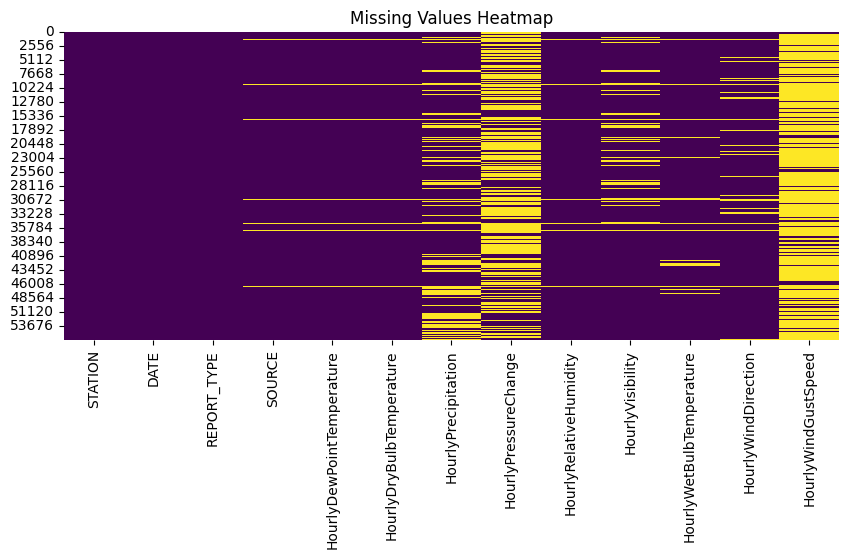


===== Duplicate Timestamps =====
Duplicates: 76

===== Data Types =====
STATION                              object
DATE                         datetime64[ns]
REPORT_TYPE                          object
SOURCE                              float64
HourlyDewPointTemperature           float64
HourlyDryBulbTemperature            float64
HourlyPrecipitation                  object
HourlyPressureChange                float64
HourlyRelativeHumidity              float64
HourlyVisibility                     object
HourlyWetBulbTemperature            float64
HourlyWindDirection                  object
HourlyWindGustSpeed                 float64
dtype: object

===== Outliers =====
       HourlyDewPointTemperature  HourlyPressureChange  HourlyWindGustSpeed  \
count               54339.000000          23342.000000         11503.000000   
mean                   65.576658             -0.000157            25.177258   
std                     3.538917              0.038073             4.172402   
min

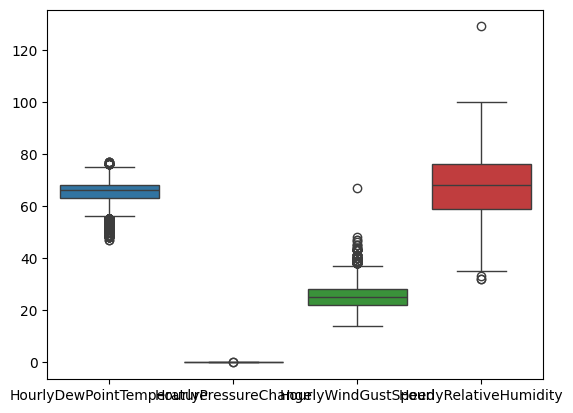

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (replace with your actual file path)
df = pd.read_csv('/content/2.Honolulu internation airport.csv', parse_dates=['DATE'])

# Task 1: Initial Data Inspection
print("===== Dataset Size =====")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")  # Verify ~44K rows

print("\n===== Missing Values =====")
print(df.isna().sum())  # Count missing values per column

# Visualize missing values
plt.figure(figsize=(10, 4))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

print("\n===== Duplicate Timestamps =====")
print("Duplicates:", df.duplicated(subset=['DATE']).sum())  # Check duplicates

print("\n===== Data Types =====")
print(df.dtypes)  # Ensure DATE is datetime

print("\n===== Outliers =====")
print(df[['HourlyPrecipitation', 'HourlyDewPointTemperature', 'HourlyPressureChange', 'HourlyWindGustSpeed', 'HourlyWindDirection', 'HourlyRelativeHumidity']].describe())
sns.boxplot(data=df[['HourlyPrecipitation', 'HourlyDewPointTemperature', 'HourlyPressureChange', 'HourlyWindGustSpeed', 'HourlyWindDirection', 'HourlyRelativeHumidity']])
plt.show()

In [72]:
df = df[~df['REPORT_TYPE'].isin(['SOM', 'SOD'])]

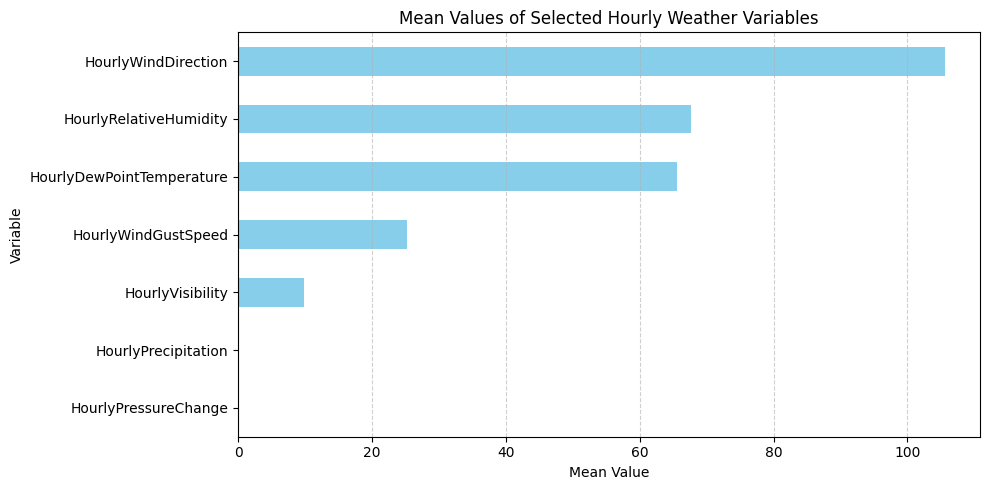

In [73]:
# List of selected variables
selected_vars = [
    'HourlyPrecipitation',
    'HourlyDewPointTemperature',
    'HourlyPressureChange',
    'HourlyWindGustSpeed',
    'HourlyWindDirection',
    'HourlyRelativeHumidity',
    'HourlyVisibility'
]

for var in selected_vars:
    df[var] = pd.to_numeric(df[var], errors='coerce')

means = df[selected_vars].mean()

# Plot as horizontal bar chart
plt.figure(figsize=(10, 5))
means.sort_values().plot(kind='barh', color='skyblue')
plt.title('Mean Values of Selected Hourly Weather Variables')
plt.xlabel('Mean Value')
plt.ylabel('Variable')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [74]:
# Task 2: Handle Missing Values
# Example: fill 0 for precipitation when surrounding values are 0
HourlyPrecipitation = df['HourlyPrecipitation']

missing = HourlyPrecipitation.isna()

# Find where both surrounding hours are 0.0
surrounding_zero = (HourlyPrecipitation.shift(1) == 0.0) & (HourlyPrecipitation.shift(-1) == 0.0)

# Fill NaNs only when both neighbors are 0.0
df.loc[missing & surrounding_zero, 'HourlyPrecipitation'] = 0.0



# Interpolate temp, pressure, humidity, visibility for short gaps
for col in ['HourlyDewPointTemperature', 'HourlyPressureChange', 'HourlyRelativeHumidity', 'HourlyVisibility']:
    df[col] = df[col].interpolate(limit=2)

# Forward fill wind direction, interpolate wind speed
df['HourlyWindGustSpeed'] = df['HourlyWindGustSpeed'].interpolate(limit=2)
df['HourlyWindDirection'] = df['HourlyWindDirection'].ffill()

# Create a missingness indicator
variables_to_check = [
    'HourlyPrecipitation',
    'HourlyDewPointTemperature',
    'HourlyPressureChange',
    'HourlyRelativeHumidity',
    'HourlyVisibility',
    'HourlyWindGustSpeed',
    'HourlyWindDirection'
]

for var in variables_to_check:
    df[f'{var}_Missing'] = df[var].isna().astype(int)

In [53]:
print(df.head)

<bound method NDFrame.head of            STATION                DATE REPORT_TYPE  SOURCE  \
2      USW00022521 2020-01-01 00:53:00       FM-15   343.0   
3      USW00022521 2020-01-01 01:53:00       FM-15   343.0   
4      USW00022521 2020-01-01 02:00:00       FM-12   223.0   
5      USW00022521 2020-01-01 02:53:00       FM-15   343.0   
6      USW00022521 2020-01-01 03:53:00       FM-15   343.0   
...            ...                 ...         ...     ...   
56226  USW00022521 2024-12-31 20:53:00       FM-15   223.0   
56227  USW00022521 2024-12-31 21:53:00       FM-15   223.0   
56228  USW00022521 2024-12-31 22:53:00       FM-15   223.0   
56229  USW00022521 2024-12-31 23:00:00       FM-12   223.0   
56230  USW00022521 2024-12-31 23:53:00       FM-15   223.0   

       HourlyDewPointTemperature  HourlyDryBulbTemperature  \
2                           61.0                      74.0   
3                           61.0                      73.0   
4                           61.0       

In [75]:
# Task 3: Create Complete Timeline
# Generate full hourly timeline
# Make sure DATE column is datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Step 1: Create full hourly timeline from start to end
full_timeline = pd.date_range(start=df['DATE'].min(), end=df['DATE'].max(), freq='H')

# Step 2: Create a new DataFrame with this timeline
timeline_df = pd.DataFrame({'DATE': full_timeline})

# Step 3: Merge original data onto complete timeline
df = pd.merge(timeline_df, df, on='DATE', how='left')

<ipython-input-75-59d094172d22>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_timeline = pd.date_range(start=df['DATE'].min(), end=df['DATE'].max(), freq='H')


In [55]:
print(df.head)

<bound method NDFrame.head of                      DATE      STATION REPORT_TYPE  SOURCE  \
0     2020-01-01 00:53:00  USW00022521       FM-15   343.0   
1     2020-01-01 01:53:00  USW00022521       FM-15   343.0   
2     2020-01-01 02:53:00  USW00022521       FM-15   343.0   
3     2020-01-01 03:53:00  USW00022521       FM-15   343.0   
4     2020-01-01 04:53:00  USW00022521       FM-15   343.0   
...                   ...          ...         ...     ...   
43843 2024-12-31 19:53:00  USW00022521       FM-15   223.0   
43844 2024-12-31 20:53:00  USW00022521       FM-15   223.0   
43845 2024-12-31 21:53:00  USW00022521       FM-15   223.0   
43846 2024-12-31 22:53:00  USW00022521       FM-15   223.0   
43847 2024-12-31 23:53:00  USW00022521       FM-15   223.0   

       HourlyDewPointTemperature  HourlyDryBulbTemperature  \
0                           61.0                      74.0   
1                           61.0                      73.0   
2                           60.0       

In [76]:
# Precipitation NAN
HourlyPrecipitation = df['HourlyPrecipitation']

# Identify missing values
missing = HourlyPrecipitation.isna()

# Check if both neighbors are 0
surrounding_zero = (HourlyPrecipitation.shift(1) == 0.0) & (HourlyPrecipitation.shift(-1) == 0.0)

# Fill only where both neighbors are 0
df.loc[missing & surrounding_zero, 'HourlyPrecipitation'] = 0.0


for col in ['HourlyDewPointTemperature', 'HourlyPressureChange', 'HourlyRelativeHumidity', 'HourlyWindGustSpeed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].interpolate(limit=2)

df['HourlyWindDirection'] = df['HourlyWindDirection'].ffill()

variables_to_check = [
    'HourlyPrecipitation',
    'HourlyDewPointTemperature',
    'HourlyPressureChange',
    'HourlyRelativeHumidity',
    'HourlyVisibility',
    'HourlyWindGustSpeed',
    'HourlyWindDirection'
]

for col in variables_to_check:
    df[f'{col}_Missing'] = df[col].isna().astype(int)


In [77]:
# Task 4: Target Variable Creation
print(df['HourlyPrecipitation'].describe())
df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')

# Create a new column in millimeters
df['HourlyPrecipitation_mm'] = df['HourlyPrecipitation'] * 25.4

df['HourlyPrecipitation_mm'] = pd.to_numeric(df['HourlyPrecipitation_mm'], errors='coerce')
threshold = df['HourlyPrecipitation_mm'].quantile(0.95)
print(f"95th percentile threshold for heavy rainfall: {threshold:.2f} mm/hour")

# Look ahead 3 hours
df['HeavyRainNext3h'] = (
    (df['HourlyPrecipitation_mm'].shift(-1) > threshold) |
    (df['HourlyPrecipitation_mm'].shift(-2) > threshold) |
    (df['HourlyPrecipitation_mm'].shift(-3) > threshold)
).astype(int)

# Check how many rows are labeled 1 vs 0 (class balance)
print("\nClass distribution of target variable:")
print(df['HeavyRainNext3h'].value_counts(normalize=True))

# View updated DataFrame
print("\nUpdated DataFrame preview:")
print(df[['DATE', 'HourlyPrecipitation_mm', 'HeavyRainNext3h']].head(10))

print(df['HeavyRainNext3h'].value_counts(normalize=True))

# Save cleaned dataset
df.to_csv('cleaned_honoluluheavyrain_data.csv', index=False)


count    37610.000000
mean         0.001872
std          0.029621
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.830000
Name: HourlyPrecipitation, dtype: float64
95th percentile threshold for heavy rainfall: 0.00 mm/hour

Class distribution of target variable:
HeavyRainNext3h
0    0.951811
1    0.048189
Name: proportion, dtype: float64

Updated DataFrame preview:
                 DATE  HourlyPrecipitation_mm  HeavyRainNext3h
0 2020-01-01 00:53:00                     0.0                0
1 2020-01-01 01:53:00                     0.0                0
2 2020-01-01 02:53:00                     0.0                0
3 2020-01-01 03:53:00                     0.0                0
4 2020-01-01 04:53:00                     0.0                0
5 2020-01-01 05:53:00                     0.0                0
6 2020-01-01 06:53:00                     0.0                0
7 2020-01-01 07:53:00                     0.0                0
8 2020-01-0

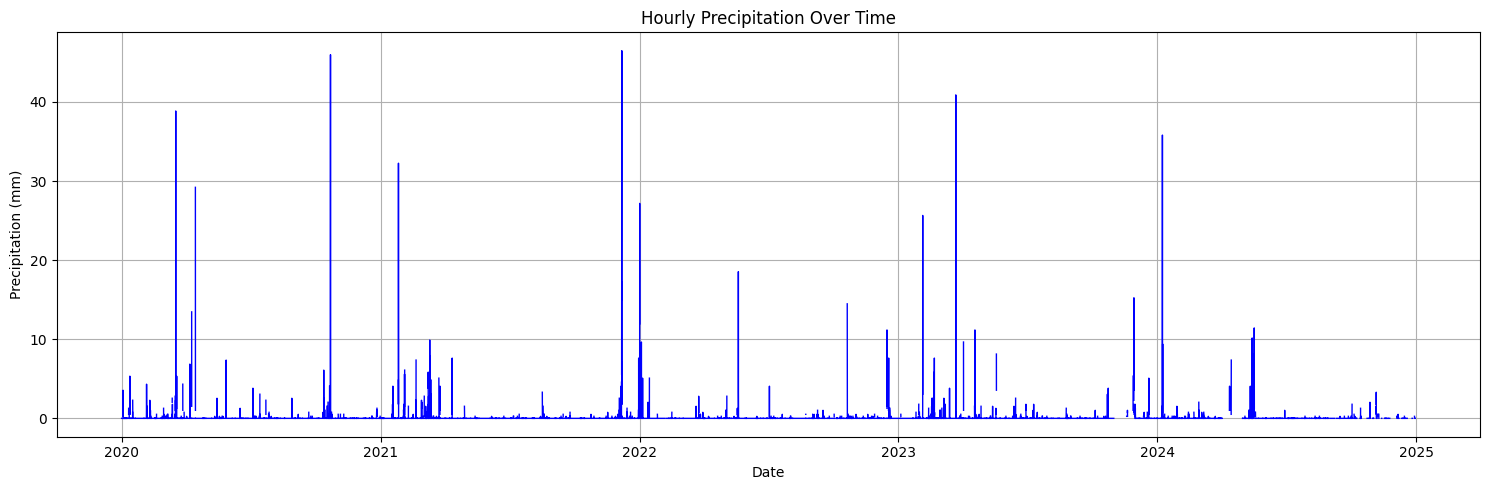

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

df['DATE'] = pd.to_datetime(df['DATE'])

# Sort by date just in case
df = df.sort_values('DATE')

# Plot precipitation over time
plt.figure(figsize=(15, 5))
plt.plot(df['DATE'], df['HourlyPrecipitation_mm'], color='blue', linewidth=1)
plt.title('Hourly Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
## Step 5: Data Splitting (+ balance data using SMOTE)
# Sort chronologically
df = df.sort_values('DATE').reset_index(drop=True)

# Get split indices
total_rows = len(df)
train_end = int(0.7 * total_rows)
val_end = int(0.85 * total_rows)

# Split
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Check class balance in each
print("Train distribution:")
print(train_df['HeavyRainNext3h'].value_counts(normalize=True))

print("\nValidation distribution:")
print(val_df['HeavyRainNext3h'].value_counts(normalize=True))

print("\nTest distribution:")
print(test_df['HeavyRainNext3h'].value_counts(normalize=True))

Train distribution:
HeavyRainNext3h
0    0.950314
1    0.049686
Name: proportion, dtype: float64

Validation distribution:
HeavyRainNext3h
0    0.95165
1    0.04835
Name: proportion, dtype: float64

Test distribution:
HeavyRainNext3h
0    0.958954
1    0.041046
Name: proportion, dtype: float64


In [89]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X_train = train_df.drop(columns=['HeavyRainNext3h'])
# Drop non-numeric columns from X_train
X_train = X_train.drop(columns=[
    'DATE',
    'STATION',
    'REPORT_TYPE',
    'SOURCE'
], errors='ignore')

X_train = X_train.fillna(X_train.median(numeric_only=True))
y_train = train_df['HeavyRainNext3h']

print("Before SMOTE:", y_train.value_counts())

Before SMOTE: HeavyRainNext3h
0    29168
1     1525
Name: count, dtype: int64


In [90]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_balanced.value_counts())

After SMOTE: HeavyRainNext3h
0    29168
1    29168
Name: count, dtype: int64


In [62]:
## Task 2: Feature Engineering
## Step 1: Basic Features from Raw Data
# Current conditions
print(df.columns)
df.info()
print(df.head)

# Basic Features from Raw Data
df['hour'] = df['DATE'].dt.hour
df['month'] = df['DATE'].dt.month
df['dayofyear'] = df['DATE'].dt.dayofyear
df['weekday'] = df['DATE'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# Cyclical features: encode hour and day of year
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)


Index(['DATE', 'STATION', 'REPORT_TYPE', 'SOURCE', 'HourlyDewPointTemperature',
       'HourlyDryBulbTemperature', 'HourlyPrecipitation',
       'HourlyPressureChange', 'HourlyRelativeHumidity', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindDirection',
       'HourlyWindGustSpeed', 'HourlyPrecipitation_Missing',
       'HourlyDewPointTemperature_Missing', 'HourlyPressureChange_Missing',
       'HourlyRelativeHumidity_Missing', 'HourlyVisibility_Missing',
       'HourlyWindGustSpeed_Missing', 'HourlyWindDirection_Missing',
       'HourlyPrecipitation_mm', 'HeavyRainNext3h'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   DATE                               43848 non-null  datetime64[ns]
 1   STATION                            43826 non-null 

In [87]:
# Step 2: Derived Weather Features
df['DewPointDepression'] = df['HourlyDryBulbTemperature'] - df['HourlyDewPointTemperature']

# Using the Magnus-Tetens approximation
df['VaporPressure_hPa'] = 6.11 * np.exp(
    (17.62 * df['HourlyDewPointTemperature']) / (243.12 + df['HourlyDewPointTemperature'])
)

# wet-bulb temperature already collected in data


# Convert direction to radians
df['HourlyWindDirection'] = pd.to_numeric(df['HourlyWindDirection'], errors='coerce')

df['WindDir_rad'] = np.radians(df['HourlyWindDirection'])

# Compute u and v components (negative sign because direction is "from")
df['u_wind'] = -df['HourlyWindGustSpeed'] * np.sin(df['WindDir_rad'])
df['v_wind'] = -df['HourlyWindGustSpeed'] * np.cos(df['WindDir_rad'])

In [84]:
# Step 3: Historical and Trend Features
# Cumulative rainfall (in mm) over past 3h, 6h, 12h, 24h
df['precip_3h_sum'] = df['HourlyPrecipitation_mm'].rolling(window=3).sum()
df['precip_6h_sum'] = df['HourlyPrecipitation_mm'].rolling(window=6).sum()
df['precip_12h_sum'] = df['HourlyPrecipitation_mm'].rolling(window=12).sum()
df['precip_24h_sum'] = df['HourlyPrecipitation_mm'].rolling(window=24).sum()

# Max rainfall in same windows
df['precip_6h_max'] = df['HourlyPrecipitation_mm'].rolling(window=6).max()
df['precip_12h_max'] = df['HourlyPrecipitation_mm'].rolling(window=12).max()

# Current rain indicator
df['is_raining_now'] = (df['HourlyPrecipitation_mm'] > 0).astype(int)

# Hours since last rain (requires cumulative logic)
df['hours_since_rain'] = df['is_raining_now'][::-1].cumsum()[::-1]
print(df['hours_since_rain'].describe())

count    43848.000000
mean       486.668423
std        286.748364
min          0.000000
25%        254.000000
50%        510.000000
75%        696.000000
max        996.000000
Name: hours_since_rain, dtype: float64


In [85]:
## changes in key variables over different time periods (1h, 3h, 6h)
# Humidity changes
df['humidity_change_1h'] = df['HourlyRelativeHumidity'] - df['HourlyRelativeHumidity'].shift(1)
df['humidity_change_3h'] = df['HourlyRelativeHumidity'] - df['HourlyRelativeHumidity'].shift(3)
df['humidity_change_6h'] = df['HourlyRelativeHumidity'] - df['HourlyRelativeHumidity'].shift(6)
# HourlyPressureChange
df['pressure_change_1h'] = df['HourlyPressureChange'] - df['HourlyPressureChange'].shift(1)
df['pressure_change_3h'] = df['HourlyPressureChange'] - df['HourlyPressureChange'].shift(3)
df['pressure_change_6h'] = df['HourlyPressureChange'] - df['HourlyPressureChange'].shift(6)
# HourlyDewPointTemperature
df['dew_change_1h'] = df['HourlyDewPointTemperature'] - df['HourlyDewPointTemperature'].shift(1)
df['dew_change_3h'] = df['HourlyDewPointTemperature'] - df['HourlyDewPointTemperature'].shift(3)
df['dew_change_6h'] = df['HourlyDewPointTemperature'] - df['HourlyDewPointTemperature'].shift(6)
# HourlyWindGustSpeed
df['wind_change_1h'] = df['HourlyWindGustSpeed'] - df['HourlyWindGustSpeed'].shift(1)
df['wind_change_3h'] = df['HourlyWindGustSpeed'] - df['HourlyWindGustSpeed'].shift(3)
df['wind_change_6h'] = df['HourlyWindGustSpeed'] - df['HourlyWindGustSpeed'].shift(6)

# e.g.Pressure rate of change per hour
df['pressure_rate'] = df['HourlyPressureChange'] - df['HourlyPressureChange'].shift(1)

In [88]:
## Step 4: Model-Specific Features
# Random Forest
# Threshold indicators
df['high_humidity'] = (df['HourlyRelativeHumidity'] > 90).astype(int)
df['rapid_pressure_drop'] = (df['HourlyPressureChange'] < -0.05).astype(int)

# Interaction terms
df['humidity_x_dewpointdepression'] = df['HourlyRelativeHumidity'] * df['DewPointDepression']
df['temp_x_dew'] = df['HourlyDryBulbTemperature'] * df['HourlyDewPointTemperature']
df['wind_x_pressure'] = df['HourlyWindGustSpeed'] * df['HourlyPressureChange']

# Normalize selected columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Remove non-numeric characters like 'V', strip spaces, then convert to float
df['HourlyVisibility'] = pd.to_numeric(df['HourlyVisibility'].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

scaled_features = scaler.fit_transform(df[[
    'HourlyDewPointTemperature', 'HourlyRelativeHumidity',
    'HourlyPressureChange', 'HourlyWindGustSpeed', 'HourlyVisibility', 'humidity_x_dewpointdepression',
    'temp_x_dew', 'wind_x_pressure'
]])

df[['norm_dew', 'norm_humidity', 'norm_pressure', 'norm_wind', 'norm_visibility', 'norm_humidity_x_dewpointdepression',
    'norm_temp_x_dew', 'norm_x_pressure']] = scaled_features


*   Low depression + high RH = very moist atmosphere
*   Temperature + DewPoint Temp = Reflects moisture + ambient air conditions
*   Strong winds + falling pressure = active system





In [67]:
## Task 3: Model Building >> ISSUE HERE

df = df.sort_values('DATE').reset_index(drop=True)

# Assign column names to the scaled features and convert to a DataFrame
scaled_feature_names = [
    'norm_dew', 'norm_humidity', 'norm_pressure', 'norm_wind',
    'norm_visibility', 'norm_humidity_x_dewpointdepression',
    'norm_temp_x_dew', 'norm_x_pressure'
]
y = df['HeavyRainNext3h']

X_scaled = pd.DataFrame(scaled_features, columns=scaled_feature_names)
X_scaled['HeavyRainNext3h'] = df['HeavyRainNext3h'].values  # Add target back

n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X_scaled.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X_scaled.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X_scaled.iloc[val_end:], y.iloc[val_end:]

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1
)

rf_model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_val_pred = rf_model.predict(X_val)
y_val_proba = rf_model.predict_proba(X_val)[:, 1]  # For ROC AUC

print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6259
           1       1.00      1.00      1.00       318

    accuracy                           1.00      6577
   macro avg       1.00      1.00      1.00      6577
weighted avg       1.00      1.00      1.00      6577

Confusion Matrix:
 [[6259    0]
 [   0  318]]
Validation ROC AUC: 1.0


In [92]:
df = df.sort_values('DATE').reset_index(drop=True)

balanced_feature_names = [
    'HourlyDewPointTemperature', 'HourlyRelativeHumidity',
    'HourlyPressureChange', 'HourlyWindGustSpeed', 'HourlyVisibility', 'humidity_x_dewpointdepression',
    'temp_x_dew', 'wind_x_pressure'
]

X_balanced = pd.DataFrame(scaled_features, columns=balanced_feature_names)
X_balanced['HeavyRainNext3h'] = df['HeavyRainNext3h'].values  # Add target back

n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X_balanced.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X_balanced.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X_balanced.iloc[val_end:], y.iloc[val_end:]

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1
)

rf_model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_val_pred = rf_model.predict(X_val)
y_val_proba = rf_model.predict_proba(X_val)[:, 1]  # For ROC AUC

print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, y_val_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6259
           1       1.00      1.00      1.00       318

    accuracy                           1.00      6577
   macro avg       1.00      1.00      1.00      6577
weighted avg       1.00      1.00      1.00      6577

Confusion Matrix:
 [[6259    0]
 [   0  318]]
Validation ROC AUC: 1.0


In [44]:
print(y_val.value_counts())

HeavyRainNext3h
0    6589
Name: count, dtype: int64


In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

best_model = grid_search.best_estimator_

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6589

    accuracy                           1.00      6589
   macro avg       1.00      1.00      1.00      6589
weighted avg       1.00      1.00      1.00      6589

ROC AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


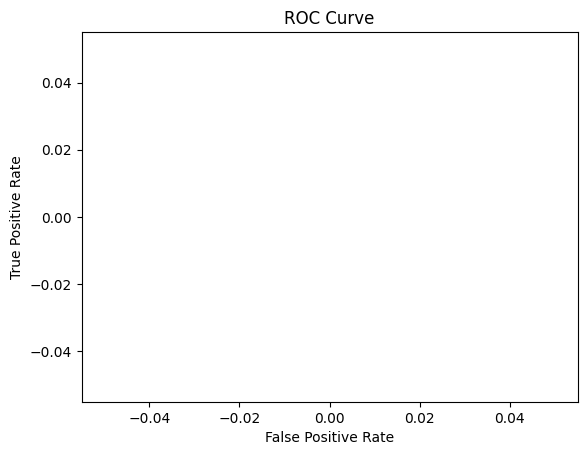

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


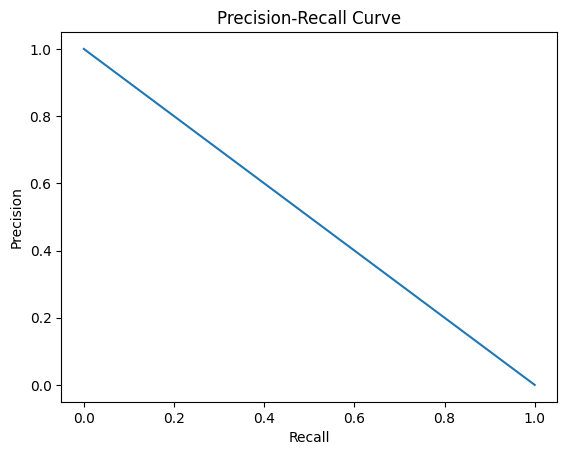

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [ ]:
# Autoencoder Model Implementation
feature_cols = [
    'norm_dew', 'norm_humidity', 'norm_pressure', 'norm_wind',
    'norm_visibility', 'norm_humidity_x_dewpointdepression',
    'norm_temp_x_dew', 'norm_x_pressure'
]

X_normal = create_sequences(normal_data[feature_cols].values, window_size=24)


def create_sequences(data, window_size=24):
    sequences = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        sequences.append(window)
    return np.array(sequences)

X_normal = create_sequences(normal_data[scaled_features].values, window_size=24)

KeyError: "None of [Index([                                                                                                                          (nan, nan, nan, nan, nan, nan, nan, nan),\n                                                                                                                                 (nan, nan, nan, nan, nan, nan, nan, nan),\n                                                                                                                                 (nan, nan, nan, nan, nan, nan, nan, nan),\n                                                                    (0.4482758620689655, 0.5, 0.45833333333333326, nan, nan, 0.7154471544715447, 0.3838905775075989, nan),\n                                                                                  (0.45402298850574696, 0.5171568627450981, 0.48611111111111105, nan, nan, nan, nan, nan),\n                                                                                   (0.45977011494252884, 0.5343137254901961, 0.5138888888888888, nan, nan, nan, nan, nan),\n                                                                                                                                 (nan, nan, nan, nan, nan, nan, nan, nan),\n                                                                                                                                 (nan, nan, nan, nan, nan, nan, nan, nan),\n                                                                                                                                 (nan, nan, nan, nan, nan, nan, nan, nan),\n                                                       (0.482758620689655, 0.6029411764705882, 0.6249999999999999, nan, nan, 0.5934959349593496, 0.3683890577507598, nan),\n       ...\n          (0.517241379310345, 0.27941176470588236, 0.29166666666666663, 0.3144768856447689, 0.9933407325194229, 0.9214092140921409, 0.619756838905775, 0.315742397137746),\n                                                   (0.5287356321839083, 0.3088235294117647, 0.40277777777777773, 0.30981346309813457, nan, nan, nan, 0.43868018286622945),\n                                                     (0.5402298850574712, 0.3382352941176471, 0.5138888888888888, 0.30515004055150047, nan, nan, nan, 0.5600278274696879),\n       (0.5517241379310345, 0.36764705882352944, 0.6249999999999999, 0.30048661800486615, 0.9933407325194229, 0.8753387533875339, 0.6060790273556231, 0.6797853309481217),\n                                                     (0.6091954022988506, 0.5147058823529411, 0.6805555555555555, 0.30048661800486615, nan, nan, nan, 0.7394156231365534),\n                                                      (0.6666666666666663, 0.6617647058823529, 0.736111111111111, 0.30048661800486615, nan, nan, nan, 0.7990459153249851),\n                                       (0.7241379310344829, 0.8088235294117646, 0.7916666666666665, nan, 0.9933407325194229, 0.3143631436314363, 0.5613981762917934, nan),\n                                                                                     (0.7011494252873562, 0.7794117647058824, 0.736111111111111, nan, nan, nan, nan, nan),\n                                                                                    (0.6781609195402301, 0.7499999999999999, 0.6805555555555555, nan, nan, nan, nan, nan),\n                                      (0.6551724137931034, 0.7205882352941176, 0.6249999999999999, nan, 0.9933407325194229, 0.43902439024390244, 0.5170212765957447, nan)],\n      dtype='object', length=43924)] are in the [columns]"

In [ ]:
X_all = create_sequences(df[feature_cols].values, window_size=24)

y_all = df['HeavyRainNext3h'].rolling(window=24).max().shift(-23).dropna().astype(int).values

from sklearn.model_selection import train_test_split

# Only normal data for training
X_train = X_normal

# Use full data for validation/testing
X_val, X_test, y_val, y_test = train_test_split(X_all, y_all, test_size=0.5, shuffle=False)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(32, activation='relu')(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(n_features, activation='relu', return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, X_val),
    shuffle=False
)

In [ ]:
import numpy as np

# Calculate reconstruction error
X_val_pred = autoencoder.predict(X_val)
val_mse = np.mean(np.mean(np.square(X_val_pred - X_val), axis=1), axis=1)

threshold = np.percentile(val_mse[y_val == 0], 95)
y_pred = (val_mse > threshold).astype(int) ## convert construction errors to binary predictions

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
